*Cost Operation Variable Variable, DBSCAN*

In [1]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.dates as mdates
import numpy as np
import xarray as xr

# Setting the verbosity level for Calliope
calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Loads all SPORE NetCDF result files, extracts and aggregates the variable `cost_operation_variable` by timestep for each SPORE, and constructs a matrix where each row is a SPORE and each column is a timestep.

In [2]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_df = data['cost_operation_variable'].to_dataframe().reset_index()
    # data_df = data_df[~data_df['techs'].str.contains(r'_to_', regex=True)]
    data_df = data_df.dropna(subset=['cost_operation_variable'])
    data_df['cost_operation_variable'] = data_df['cost_operation_variable'] / 3

    aggregated_flow_cap = data_df.groupby(['timesteps'])['cost_operation_variable'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_flow_cap.set_index('timesteps')['cost_operation_variable']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_flow_cap['timesteps']

# Show the resulting matrix
aggregated_matrix


timesteps        2019-01-01 00:00:00  2019-01-01 03:00:00  \
spore_5                  2354.554747          2235.835966   
minons_spore_8           2256.597959          2137.896714   
minoff_spore_7           2400.938892          2282.661108   
maxpv_spore_3              50.302992           -68.390511   
maxbat_spore_3           -229.199471          -347.786499   
...                              ...                  ...   
minpv_spore_4            2036.158428          1917.624569   
maxoff_spore_5           -382.113383          -525.901638   
minbat_spore_1            300.470246           160.637345   
maxbio_spore_10          -224.034615          -329.598756   
maxnuc_spore_4           -232.168147          -350.775906   

timesteps        2019-01-01 06:00:00  2019-01-01 09:00:00  \
spore_5                  2278.058704          2094.035956   
minons_spore_8           2180.194597          1996.237079   
minoff_spore_7           2324.764040          1954.837124   
maxpv_spore_3             -26.271574          -290.043032   
maxbat_spore_3           -305.548823          -489.404975   
...                              ...                  ...   
minpv_spore_4            1959.139359          1782.128965   
maxoff_spore_5           -511.884242          -689.692434   
minbat_spore_1            205.660280             4.320610   
maxbio_spore_10          -289.087345          -439.066238   
maxnuc_spore_4           -308.519740          -492.369635   

timesteps        2019-01-01 12:00:00  2019-01-01 15:00:00  \
spore_5                  2057.844228          2420.198130   
minons_spore_8           1960.107405          2322.541042   
minoff_spore_7           1995.234011          2467.059118   
maxpv_spore_3            -458.204656           114.643918   
maxbat_spore_3           -525.499375          -163.422198   
...                              ...                  ...   
minpv_spore_4            1738.422569          2100.977507   
maxoff_spore_5           -734.622768          -452.563977   
minbat_spore_1            -34.182120           369.429114   
maxbio_spore_10          -476.218041          -153.438525   
maxnuc_spore_4           -528.487874          -166.450945   

timesteps        2019-01-01 18:00:00  2019-01-01 21:00:00  \
spore_5                  2307.547686          2160.612301   
minons_spore_8           2209.951422          2062.816856   
minoff_spore_7           2354.477674          2208.003265   
maxpv_spore_3               3.472279          -143.524569   
maxbat_spore_3           -275.767749          -422.732093   
...                              ...                  ...   
minpv_spore_4            1989.436034          1842.576351   
maxoff_spore_5           -623.425545          -745.360369   
minbat_spore_1            233.374939            60.429885   
maxbio_spore_10          -256.462540          -385.875600   
maxnuc_spore_4           -278.829605          -425.767873   

timesteps        2019-01-02 00:00:00  2019-01-02 03:00:00  ...  \
spore_5                  2076.199774          2201.636450  ...   
minons_spore_8           1978.201469          2103.836076  ...   
minoff_spore_7           2123.635367          2248.737535  ...   
maxpv_spore_3            -228.107489          -102.518413  ...   
maxbat_spore_3           -507.301097          -381.792295  ...   
...                              ...                  ...  ...   
minpv_spore_4            1758.093013          1883.653468  ...   
maxoff_spore_5           -806.833534          -660.058247  ...   
minbat_spore_1            -37.332969           117.214050  ...   
maxbio_spore_10          -457.119258          -354.046508  ...   
maxnuc_spore_4           -510.341665          -384.801378  ...   

timesteps        2019-12-30 18:00:00  2019-12-30 21:00:00  \
spore_5                  2812.866003          2717.997774   
minons_spore_8           2715.425454          2619.973660   
minoff_spore_7           2860.926167          2765.651292   
maxpv_spore_3            1654.0

Standardizes the aggregated matrix data using `StandardScaler` to prepare for clustering.

In [3]:
# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

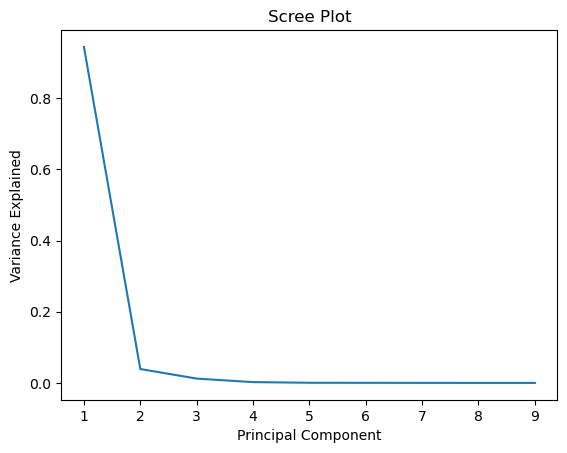

In [4]:
pca = PCA(n_components=9)
#fit PCA model to data
pca_fit = pca.fit(matrix_scaled)
# plot the scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_)
plt.title( 'Scree Plot') 
plt.xlabel( 'Principal Component')
plt.ylabel( 'Variance Explained')
plt.show()

In [5]:
# Reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(matrix_scaled)

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance)

print(f"Explained variance by Component 1: {explained_variance[0]:.4f}")
print(f"Explained variance by Component 2: {explained_variance[1]:.4f}")
print(f"Total variance explained by the first 2 components: {total_variance_explained:.4f}")

Explained variance by Component 1: 0.9436
Explained variance by Component 2: 0.0392
Total variance explained by the first 2 components: 0.9829


In [1]:
plt.figure(figsize=(10, 6))
plt.plot(pca.components_[0])
plt.title('1st Principal Component (Loadings)')
plt.xlabel('Hour of Year')
plt.ylabel('Component Weight')

NameError: name 'plt' is not defined

Applies DBSCAN clustering to the standardized data and prints the number of clusters found.

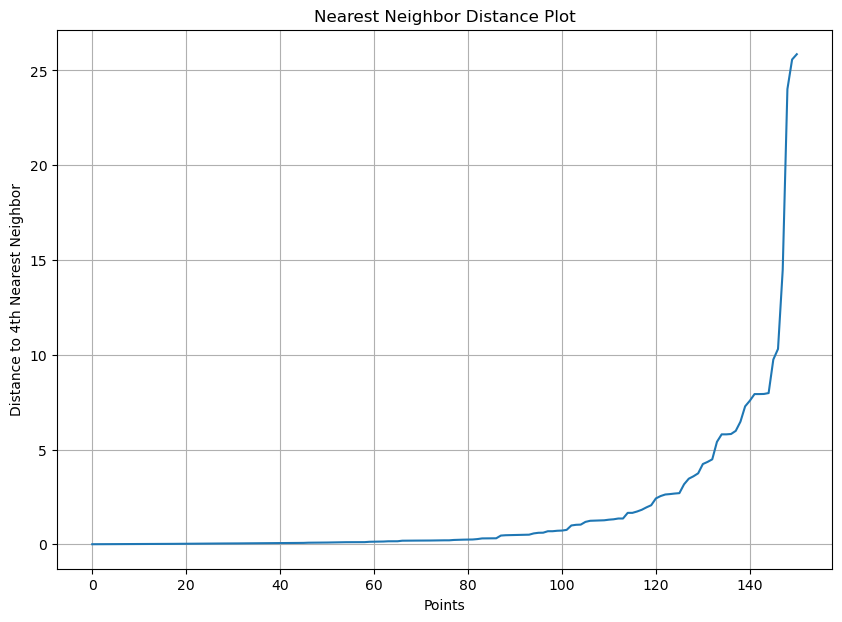

In [7]:
from sklearn.neighbors import NearestNeighbors

# Calculate the nearest neighbor distances
n_neighbors = 4  # You can adjust this value based on your analysis needs
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort the distances in ascending order
distances = np.sort(distances[:,n_neighbors-1], axis=0)

# Plot the distances
plt.figure(figsize=(10, 7))
plt.plot(distances)
plt.title('Nearest Neighbor Distance Plot')
plt.xlabel('Points')
plt.grid(True)
plt.ylabel('Distance to 4th Nearest Neighbor')
plt.show()


In [8]:
from sklearn.cluster import DBSCAN

# eps: The maximum distance between two points for them to be considered as part of the same neighborhood. 
# min_samples: The number of points required to form a dense region (a cluster).
dbscan = DBSCAN(eps=10, min_samples=4)
cluster_labels = dbscan.fit_predict(X_pca)

# Add the DBSCAN cluster labels to the aggregated_matrix
aggregated_matrix['Cluster_DBSCAN'] = cluster_labels


In [9]:
# Check the number of points in each cluster
print(aggregated_matrix['Cluster_DBSCAN'].value_counts())

Cluster_DBSCAN
 0    66
 2    45
 1    20
 3    10
 4     7
-1     3
Name: count, dtype: int64


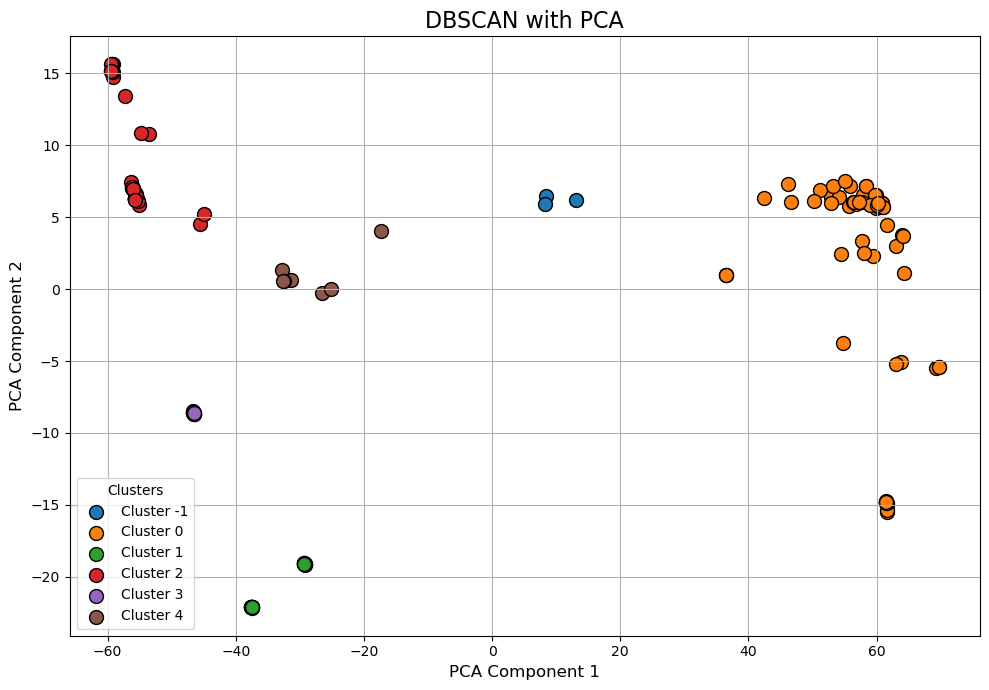

In [10]:
markers = ['o'] 

plt.figure(figsize=(10, 7))
for i, cluster in enumerate(np.unique(aggregated_matrix['Cluster_DBSCAN'])):
    plt.scatter(X_pca[aggregated_matrix['Cluster_DBSCAN'] == cluster, 0], 
                X_pca[aggregated_matrix['Cluster_DBSCAN'] == cluster, 1], 
                label=f'Cluster {cluster}', 
                marker=markers[i % len(markers)], s=100, edgecolor='k')

# Add titles and labels
plt.title('DBSCAN with PCA', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Show the plot
plt.legend(title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

[2025-06-16 20:39:44] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_1265/2092913774.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(np.unique(aggregated_matrix['Cluster_DBSCAN'])))



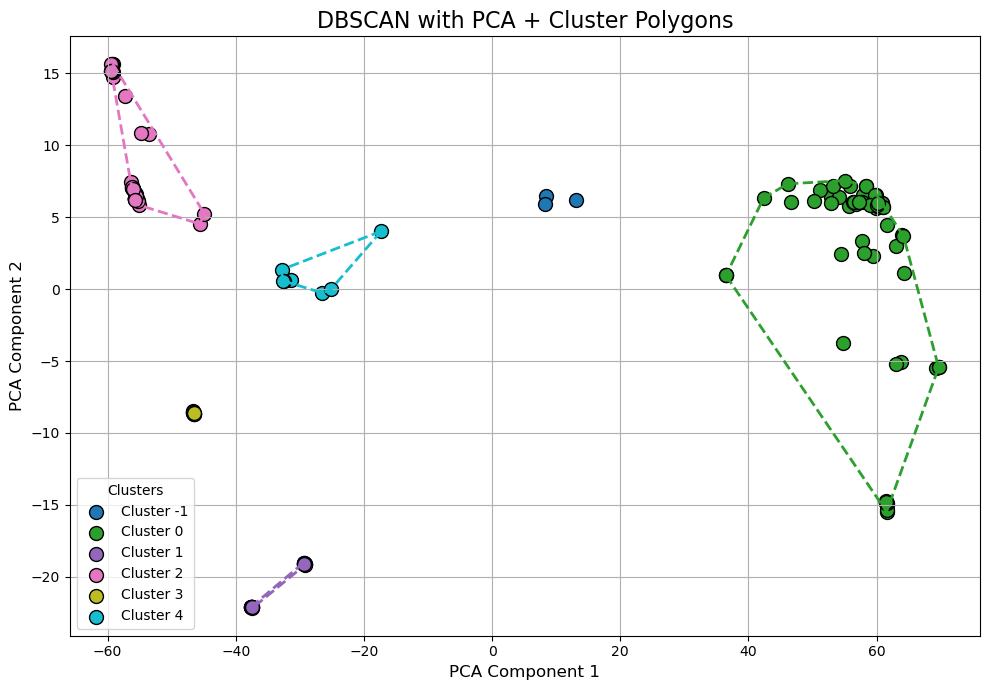

In [11]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(np.unique(aggregated_matrix['Cluster_DBSCAN'])))

for i, cluster in enumerate(np.unique(aggregated_matrix['Cluster_DBSCAN'])):
    mask = aggregated_matrix['Cluster_DBSCAN'] == cluster
    X_cluster = X_pca[mask]

    # Scatter plot for the cluster
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1],
                label=f'Cluster {cluster}',
                marker=markers[i % len(markers)], s=100,
                edgecolor='k', color=colors(i))

    # Draw convex hull polygon (only if enough points)
    if len(X_cluster) >= 3 and cluster != -1:  # skip noise
        hull = ConvexHull(X_cluster)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close the loop
        plt.plot(X_cluster[hull_points, 0], X_cluster[hull_points, 1],
                 linestyle='--', linewidth=2, color=colors(i))

# Add titles and labels
plt.title('DBSCAN with PCA + Cluster Polygons', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

mask = cluster_labels != -1

db_score = davies_bouldin_score(X_pca[mask], cluster_labels[mask])
print(f"Davies-Bouldin score: {db_score:.3f}")
db_score_orig = davies_bouldin_score(matrix_scaled[mask], cluster_labels[mask])
print(f"DB score on original space: {db_score_orig:.3f}")

# Clusters from PCA-based clustering
ch_score_pca = calinski_harabasz_score(X_pca[mask], cluster_labels[mask])
print(f"CH score on PCA space: {ch_score_pca:.2f}")
ch_score_orig = calinski_harabasz_score(matrix_scaled[mask], cluster_labels[mask])
print(f"CH score on original space: {ch_score_orig:.2f}")

score = silhouette_score(X_pca[mask], cluster_labels[mask])
print(f'Silhouette score: {score:.3f}')
sh_score_orig = silhouette_score(matrix_scaled[mask], cluster_labels[mask])
print(f"SC score on original space: {sh_score_orig:.3f}")

metrics_summary = {
    'Davies-Bouldin': db_score_orig,
    'Calinski-Harabasz': ch_score_orig,
    'Silhouette': sh_score_orig
}
metrics_summary = pd.DataFrame({
    'score': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'value': [sh_score_orig, db_score_orig, ch_score_orig]
})

Davies-Bouldin score: 0.304
DB score on original space: 0.694
CH score on PCA space: 1813.65
CH score on original space: 1019.68
Silhouette score: 0.815
SC score on original space: 0.734


Extracts a general SPORE category from each configuration, groups by cluster and category, and counts the occurrences in a summary table.

In [44]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster_DBSCAN', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count['spore_main'] = cluster_spore_count[['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10']].sum(axis=1)
cluster_spore_count = cluster_spore_count.drop(columns=['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10'])

cluster_spore_count

spore_category_general  maxbat  maxbio  maxhtp  maxnuc  maxoff  maxons  maxpv  \
Cluster_DBSCAN                                                                  
-1                           0       0       0       0       0       0      0   
 0                           0       0       0       0       0       0      0   
 1                           0       0       0       0       0      10     10   
 2                          10      10      10      10       0       0      0   
 3                           0       0       0       0      10       0      0   
 4                           0       0       0       0       0       0      0   

spore_category_general  minbat  minbio  minhtp  minnuc  minoff  minons  minpv  \
Cluster_DBSCAN                                                                  
-1                           0       0       0       0       2       0      1   
 0                           9      10       9       9       7       9      8   
 1                           0       0       0       0       0       0      0   
 2                           0       0       0       0       0       0      0   
 3                           0       0       0       0       0       0      0   
 4                           1       0       1       1       1       1      1   

spore_category_general  spore_baseline  spore_main  
Cluster_DBSCAN                                      
-1                                   0           0  
 0                                   0           5  
 1                                   0           0  
 2                                   1           4  
 3                                   0           0  
 4                                   0           1

In [45]:
# remove the noise data points
aggregated_matrix = aggregated_matrix[aggregated_matrix['Cluster_DBSCAN'] != -1]

Calculates and displays the mean value for each technology in each cluster.

In [46]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_DBSCAN').mean()

# Show the resulting cluster summary
cluster_summary


timesteps       2019-01-01 00:00:00  2019-01-01 03:00:00  2019-01-01 06:00:00  \
Cluster_DBSCAN                                                                  
0                       2205.892633          2069.678838          2120.881064   
1                       -250.633868          -408.475645          -377.974308   
2                       -211.259891          -325.652403          -284.390330   
3                       -382.184543          -525.946874          -511.918477   
4                        255.841904           125.442105           169.630897   

timesteps       2019-01-01 09:00:00  2019-01-01 12:00:00  2019-01-01 15:00:00  \
Cluster_DBSCAN                                                                  
0                       1921.107939          1872.022255          2261.421619   
1                       -555.890955          -680.854795          -277.933642   
2                       -460.217005          -495.537944          -144.971331   
3                       -689.727310          -734.657104          -452.544648   
4                        -27.010126           -69.287753           328.801631   

timesteps       2019-01-01 18:00:00  2019-01-01 21:00:00  2019-01-02 00:00:00  \
Cluster_DBSCAN                                                                  
0                       2141.882616          1973.014786          1863.151821   
1                       -430.069388          -566.608779          -648.251017   
2                       -253.560716          -395.167853          -475.945399   
3                       -623.434191          -745.382619          -806.850536   
4                        204.558658            37.864023           -52.217911   

timesteps       2019-01-02 03:00:00  ...  2019-12-30 18:00:00  \
Cluster_DBSCAN                       ...                        
0                       2027.874337  ...          2795.700625   
1                       -497.656890  ...           826.709510   
2                       -356.881046  ...           309.451013   
3                       -660.082329  ...           366.721469   
4                         92.627924  ...           975.254338   

timesteps       2019-12-30 21:00:00  2019-12-31 00:00:00  2019-12-31 03:00:00  \
Cluster_DBSCAN                                                                  
0                       2700.803138          2616.899693          2727.415203   
1                        675.868641           566.481219          1140.900484   
2                        141.105392            68.850532           197.398700   
3                        327.000240           121.018866           473.153124   
4                        789.770451           679.421721           877.972174   

timesteps       2019-12-31 06:00:00  2019-12-31 09:00:00  2019-12-31 12:00:00  \
Cluster_DBSCAN                                                                  
0                       3071.005299          2757.607758          2742.154949   
1                       1963.147368          1197.395492          1104.385599   
2                        638.560770           206.191276           187.379477   
3                       1332.294962           680.305155           636.879263   
4                       1487.101483           959.712973           917.288252   

timesteps       2019-12-31 15:00:00  2019-12-31 18:00:00  2019-12-31 21:00:00  
Cluster_DBSCAN                                                                 
0                       3232.847128          3039.283061          2911.310266  
1                       2152.548700          1956.132964          1834.641023  
2                        805.629248           604.586583           448.513718  
3                       1496.445866          1261.925908          1097.702465  
4                       1623.076861          1424.116105          1119.897365  

[5 rows x 2920 columns]

Plots the centroid values (mean per cluster) over time for each cluster.

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Define consistent cluster list (sorted for reproducibility)
cluster_ids = sorted(aggregated_matrix['Cluster_DBSCAN'].unique())

# Create color map
color_map = plt.cm.get_cmap('tab10', len(cluster_ids))
cluster_color_map = {cluster: color_map(i) for i, cluster in enumerate(cluster_ids)}


[2025-06-15 17:34:01] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_5108/3294821223.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(cluster_ids))



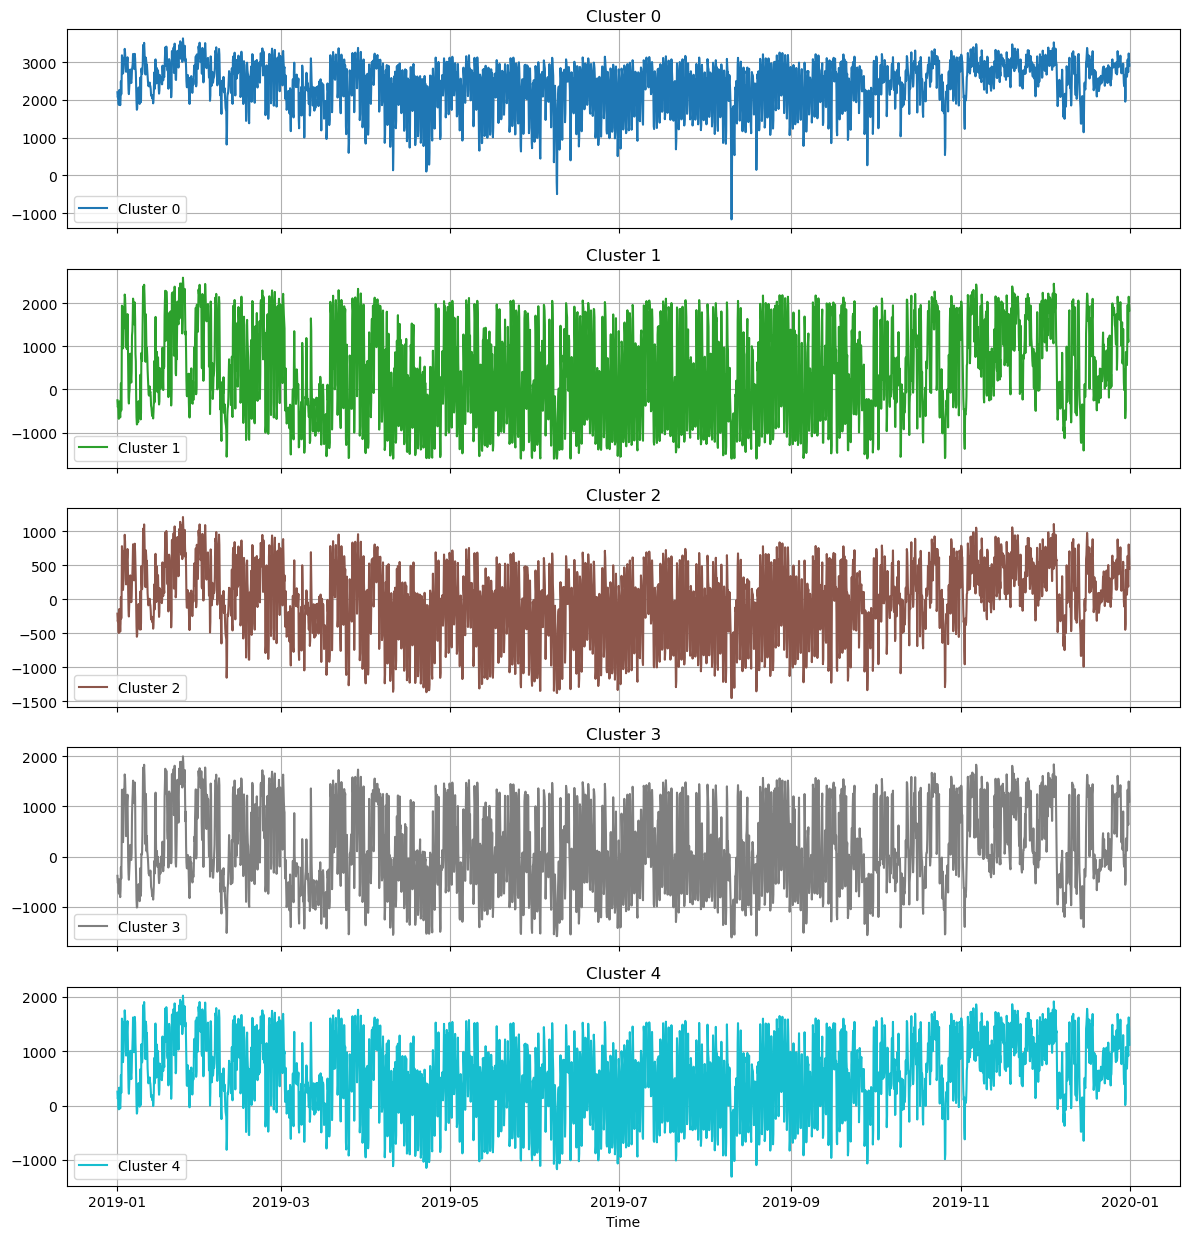

In [48]:
n_clusters = len(cluster_summary)
fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 2.5 * n_clusters), sharex=True)

for i, (cluster, ax) in enumerate(zip(cluster_summary.index, axes)):
    ax.plot(cluster_summary.columns, cluster_summary.loc[cluster], label=f'Cluster {cluster}', color=cluster_color_map[cluster])
    ax.set_title(f'Cluster {cluster}')
    ax.grid(True)
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

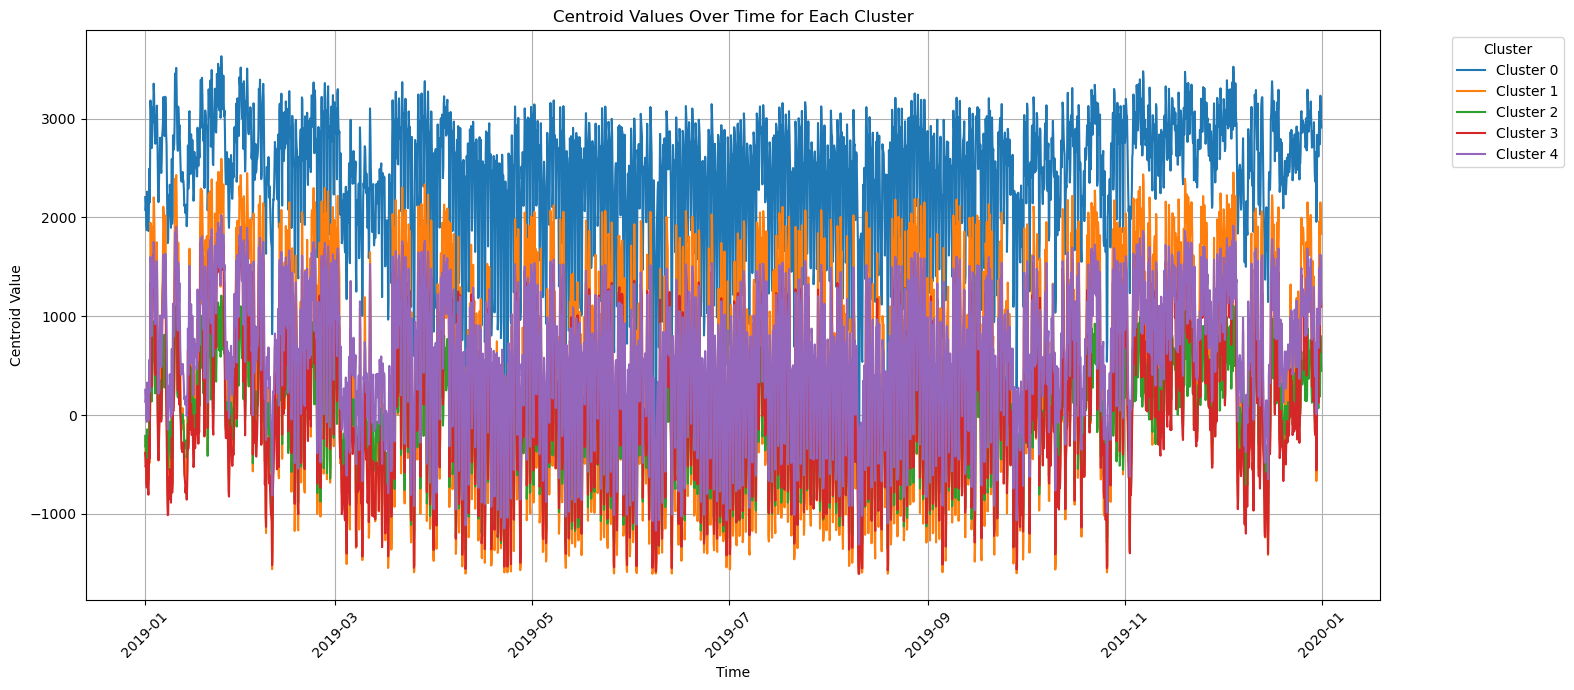

In [49]:
# Let's plot the data (one line for each cluster)
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over time (columns)
for cluster in cluster_summary.index:
    plt.plot(cluster_summary.columns, cluster_summary.loc[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Time for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

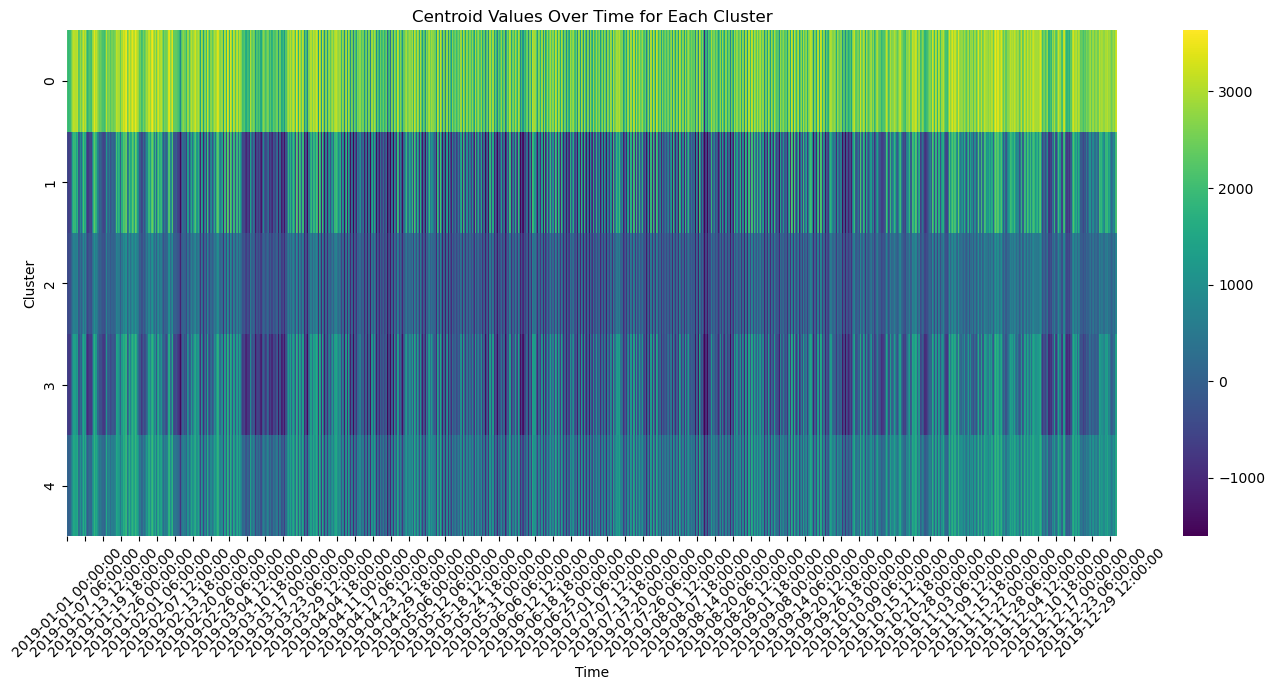

In [50]:
import seaborn as sns

# You can plot a heatmap to visualize the matrix more effectively
plt.figure(figsize=(14, 7))
sns.heatmap(cluster_summary, cmap='viridis', xticklabels=50, yticklabels=True)  # Adjust xticklabels and yticklabels
plt.title('Centroid Values Over Time for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.tight_layout()
plt.show()


In [51]:
import plotly.express as px

# Convert to DataFrame if not already
cluster_df = cluster_summary.T  # Transpose to have time as index

# Plot interactive line plot with Plotly
fig = px.line(cluster_df, title="Centroid Values Over Time for Each Cluster", labels={'index': 'Time', 'value': 'Centroid Value'})
fig.show()


[2025-06-15 17:34:10] WARNING  /Users/lucazerotre/miniforge3/envs/calliope_NL/lib/python3.12/site-packages/narwhals/_pandas_like/series.py:202: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Series constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return cls.from_native(ns.Series(data, name=name, **kwds), context=context)



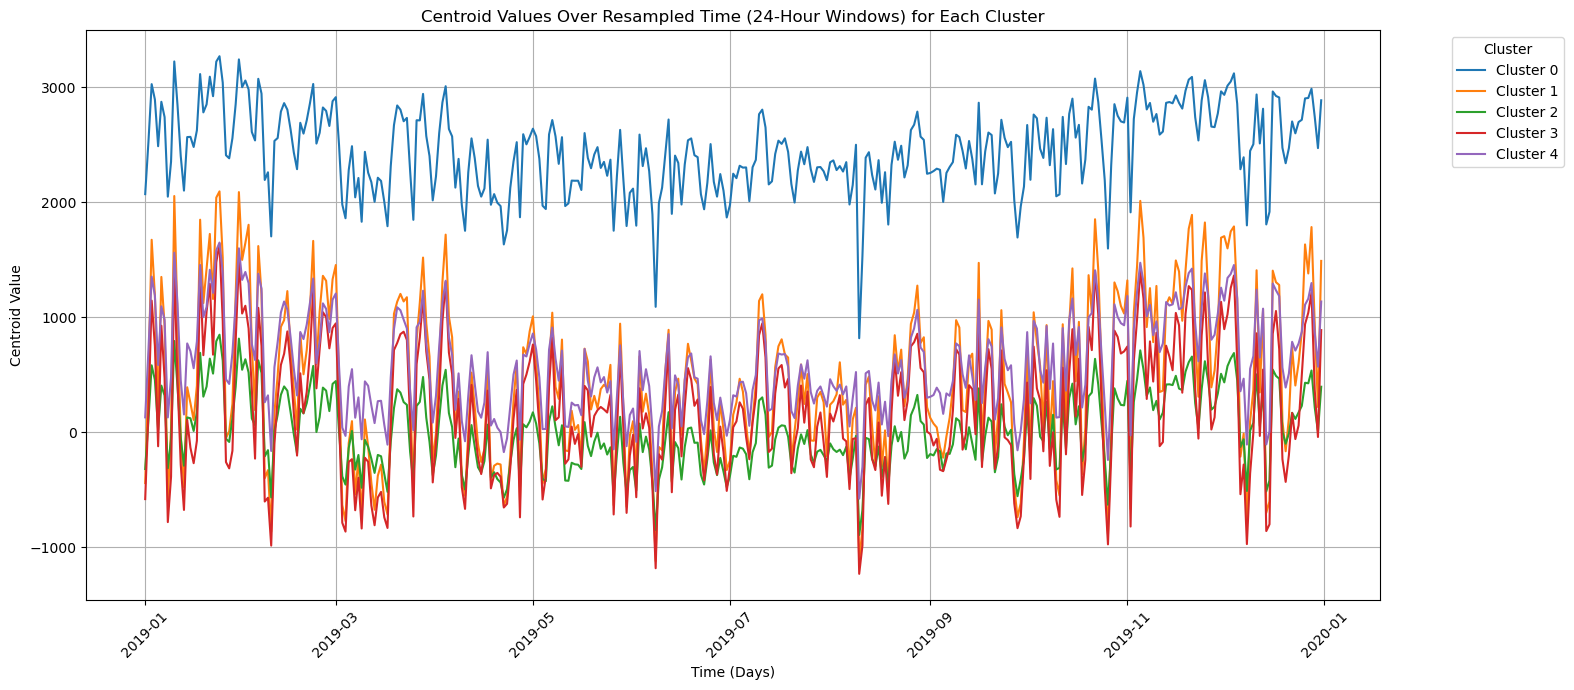

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the timesteps (columns) are in datetime format
cluster_summary.columns = pd.to_datetime(cluster_summary.columns)

# Convert the rows (clusters) into columns for easier processing
cluster_summary_T = cluster_summary.T  # Transpose to make timesteps the rows

# Now resample the data by averaging over every 24-hour period (group by day)
cluster_resampled = cluster_summary_T.resample('D').mean()

# Plot the resampled centroid values over time
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over the resampled time
for cluster in cluster_resampled.columns:
    plt.plot(cluster_resampled.index, cluster_resampled[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Resampled Time (24-Hour Windows) for Each Cluster')
plt.xlabel('Time (Days)')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


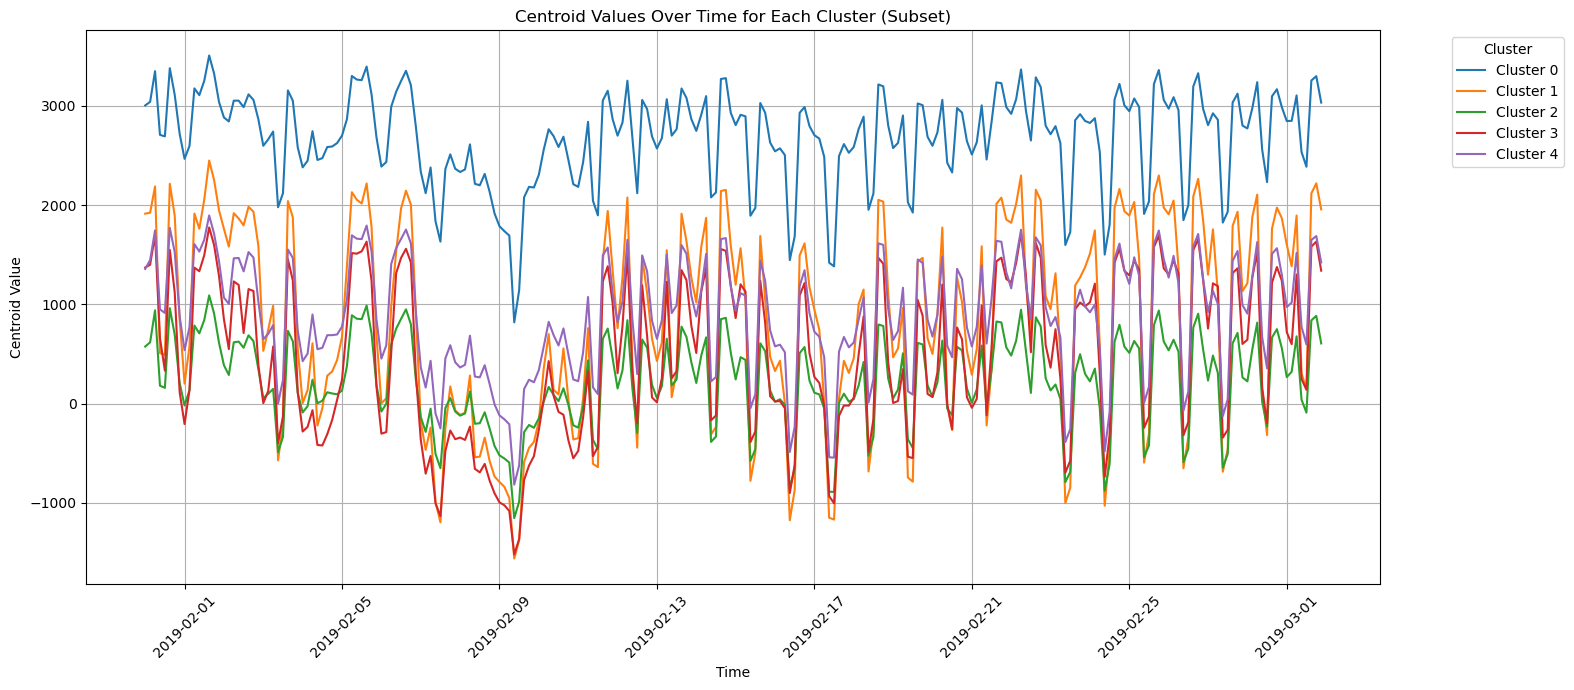

In [53]:
first_month = 240
last_month = 480
# Define the time range of interest based on user input
time_subset = cluster_summary.columns[first_month:last_month]  # Adjust as necessary
# Subset the data
cluster_subset = cluster_summary[time_subset]

# Plot the data (one line for each cluster)
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over the subset of time
for cluster in cluster_subset.index:
    plt.plot(cluster_subset.columns, cluster_subset.loc[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Time for Each Cluster (Subset)')
plt.xlabel('Time')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Finds the configuration closest to the centroid for each cluster (representative configuration) and plots their time series.

Cluster 0 - Shape of cluster_configs: (66, 2920)
Cluster 1 - Shape of cluster_configs: (20, 2920)
Cluster 2 - Shape of cluster_configs: (45, 2920)
Cluster 3 - Shape of cluster_configs: (10, 2920)
Cluster 4 - Shape of cluster_configs: (7, 2920)
Representative configurations: ['minpv_spore_7', 'maxpv_spore_9', 'maxhtp_spore_10', 'maxoff_spore_6', 'minhtp_spore_1']


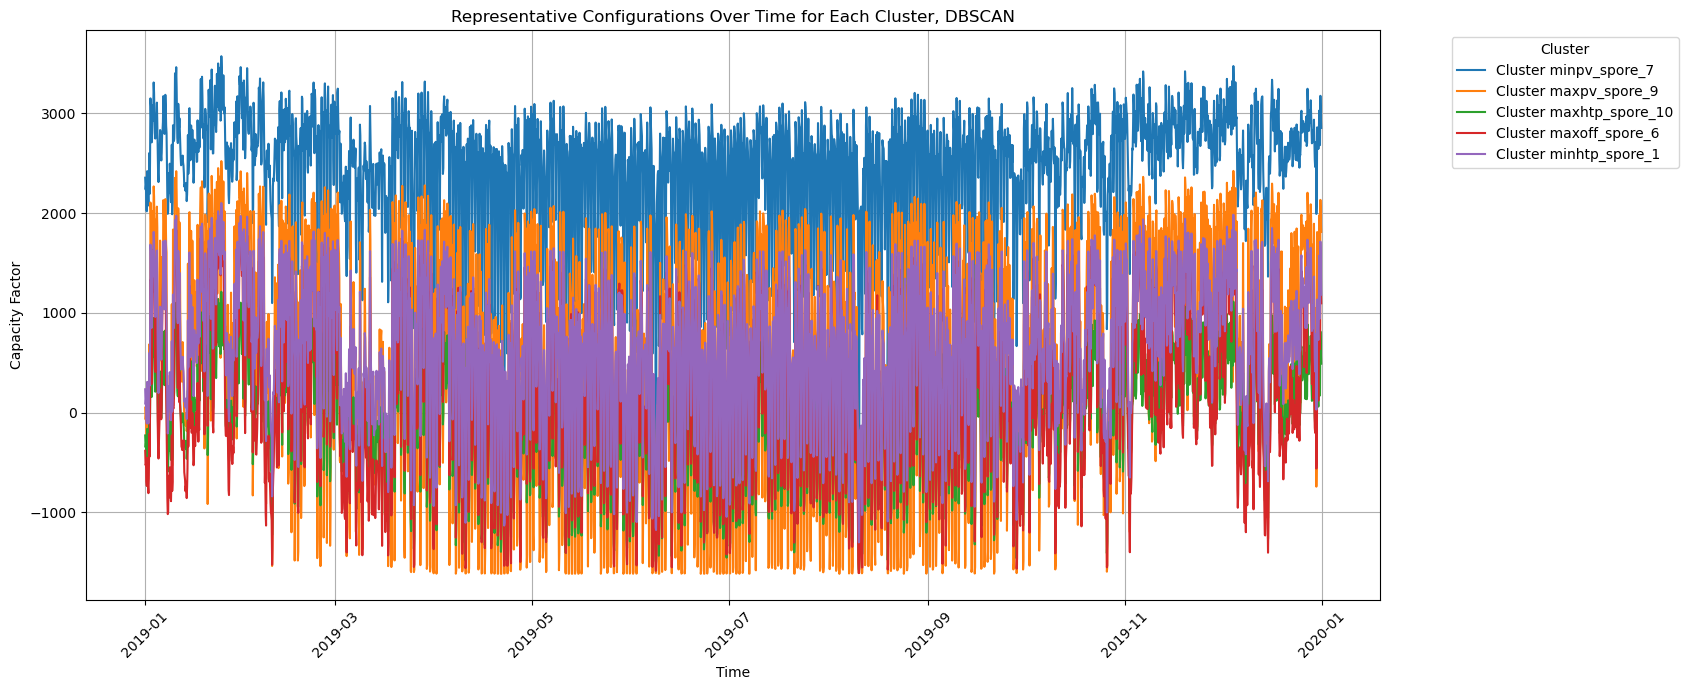

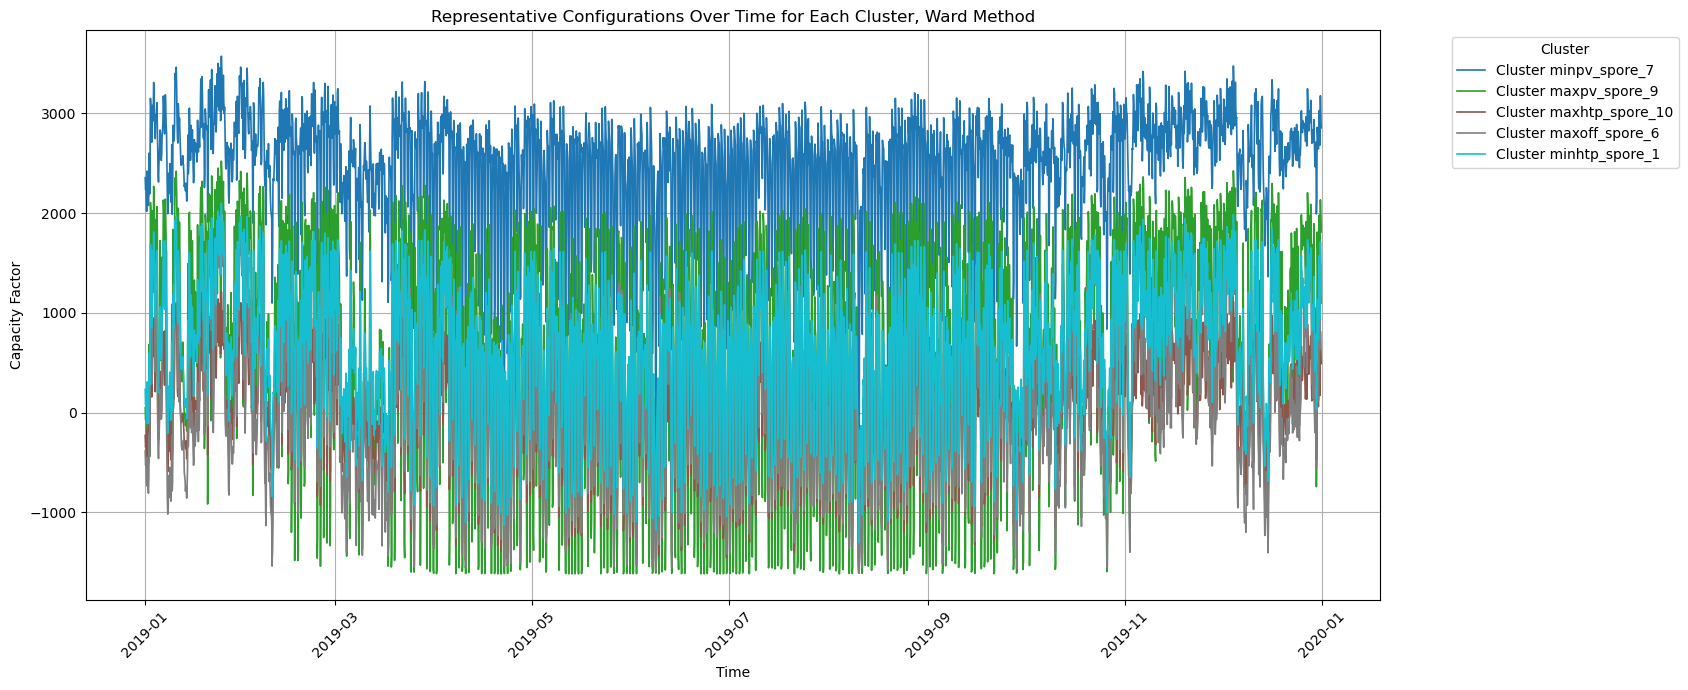

In [54]:
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_DBSCAN').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_DBSCAN'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_DBSCAN'] == cluster].drop(columns=['Cluster_DBSCAN'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs].drop(columns=['Cluster_DBSCAN'])

plt.figure(figsize=(14, 7))

# Loop through each configuration in 'df_representative_configs' and plot the time series for each cluster
for config in df_representative_configs.index:
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'Cluster {config}')

# Customize the plot
plt.title('Representative Configurations Over Time for Each Cluster, DBSCAN')
plt.xlabel('Time')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(14, 7))

# Use the predefined colors
for config in df_representative_configs.index:
    cluster_id = aggregated_matrix.loc[config, 'Cluster_DBSCAN']
    config_data = df_representative_configs.loc[config]
    
    plt.plot(df_representative_configs.columns, config_data,
             label=f'Cluster {config}',
             color=cluster_color_map[cluster_id], linewidth=1.2)

# Customize the plot
plt.title('Representative Configurations Over Time for Each Cluster, Ward Method')
plt.xlabel('Time')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

[2025-06-15 17:39:06] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_5108/814527683.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.




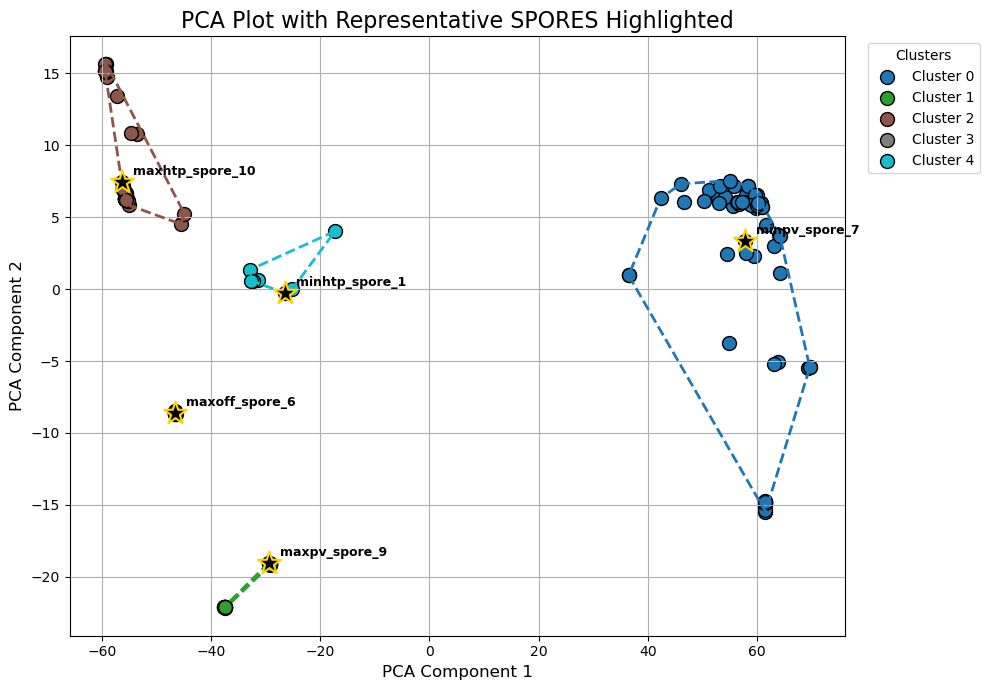

In [57]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

X_plot = X_pca.copy()
X_plot = X_plot[mask]

markers = ['o']
clusters_p = np.unique(aggregated_matrix['Cluster_DBSCAN'])
colors = plt.cm.get_cmap('tab10', len(clusters_p))

plt.figure(figsize=(10, 7))

# Plot clusters and convex hulls
for i, cluster in enumerate(clusters_p):
    mask_c = aggregated_matrix['Cluster_DBSCAN'] == cluster
    X_cluster = X_plot[mask_c]

    plt.scatter(X_cluster[:, 0], X_cluster[:, 1],
                label=f'Cluster {cluster}',
                marker=markers[i % len(markers)], s=100,
                edgecolor='k', color=colors(i))

    if len(X_cluster) >= 3:
        hull = ConvexHull(X_cluster)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        plt.plot(X_cluster[hull_points, 0], X_cluster[hull_points, 1],
                 linestyle='--', linewidth=2, color=colors(i))

# ⭐ Highlight representative configurations
for rep_idx in representative_configs:
    int_idx = aggregated_matrix.index.get_loc(rep_idx)
    x, y = X_plot[int_idx]

    plt.scatter(x, y, color='black', marker='*', s=300, edgecolor='gold', linewidth=1.5, zorder=5)
    plt.annotate(rep_idx, (x, y), textcoords="offset points", xytext=(8, 5),
                 ha='left', fontsize=9, weight='bold', color='black')

# Labels and legend
plt.title("PCA Plot with Representative SPORES Highlighted", fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



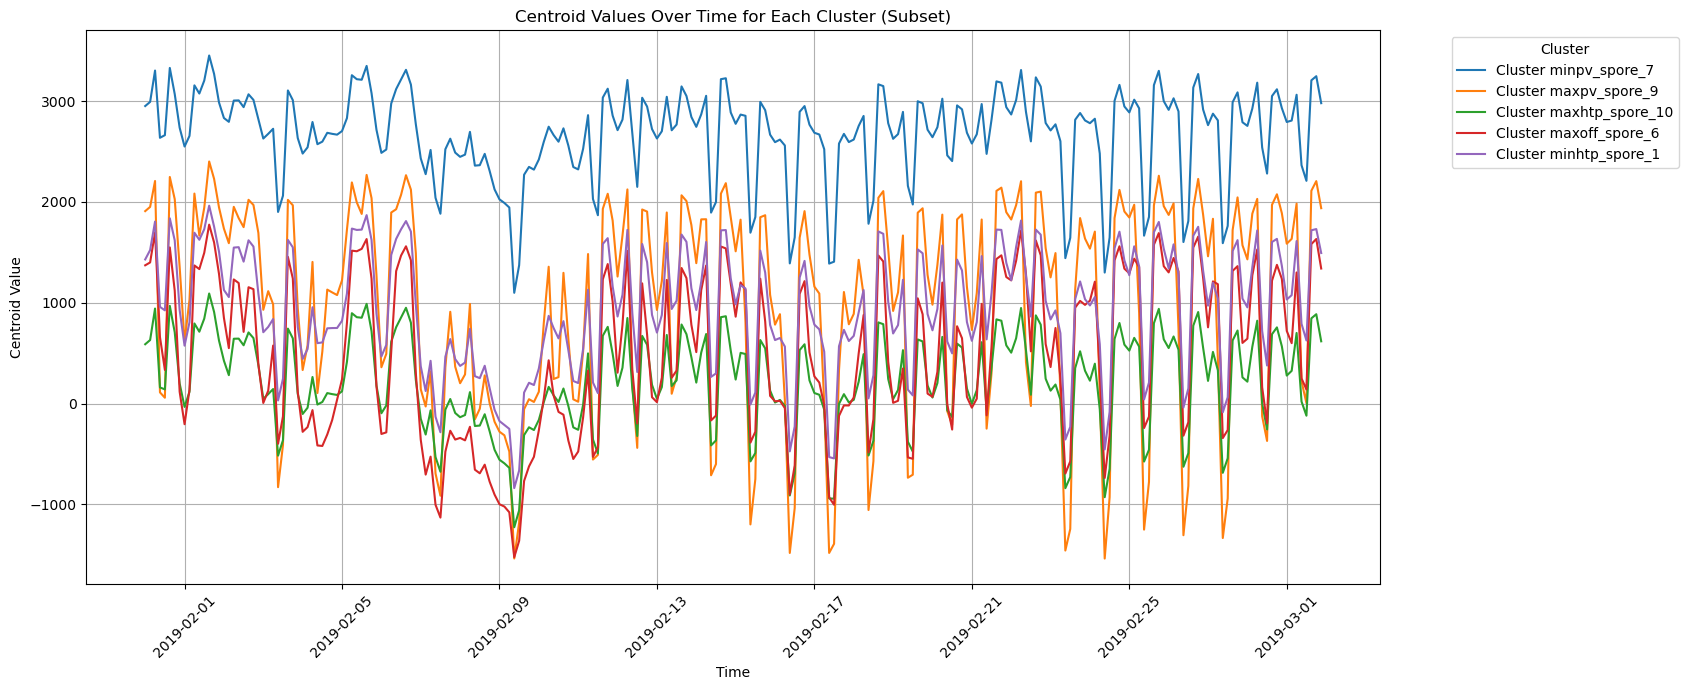

In [58]:
first_month = 240
last_month = 480
# Define the time range of interest based on user input
time_subset = df_representative_configs.columns[first_month:last_month]  # Adjust as necessary
# Subset the data
cluster_subset = df_representative_configs[time_subset]

# Plot the data (one line for each cluster)
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over the subset of time
for cluster in cluster_subset.index:
    plt.plot(cluster_subset.columns, cluster_subset.loc[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Time for Each Cluster (Subset)')
plt.xlabel('Time')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [59]:
import plotly.express as px

# Convert to DataFrame if not already
cluster_df = df_representative_configs.T  # Transpose to have time as index

# Plot interactive line plot with Plotly
fig = px.line(cluster_df, title="Centroid Values Over Time for Each Cluster", labels={'index': 'Time', 'value': 'Centroid Value'})
fig.show()

[2025-06-15 17:42:58] WARNING  /Users/lucazerotre/miniforge3/envs/calliope_NL/lib/python3.12/site-packages/narwhals/_pandas_like/series.py:202: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Series constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.




Computes various statistical metrics (max, min, mean, variance, percentiles, etc.) for each representative configuration and displays them in a table.

In [60]:
# 1. Compute the metrics for each configuration
metrics = {
    'max_value': df_representative_configs.max(axis=1),
    'min_value': df_representative_configs.min(axis=1),
    'mean_value': df_representative_configs.mean(axis=1),
    'variance_value': df_representative_configs.var(axis=1),
    'std_dev_value': df_representative_configs.std(axis=1),
    'range_value': df_representative_configs.max(axis=1) - df_representative_configs.min(axis=1),
    'percentile_25': df_representative_configs.quantile(0.25, axis=1),
    'percentile_50': df_representative_configs.quantile(0.5, axis=1),
    'percentile_75': df_representative_configs.quantile(0.75, axis=1),
}

# Convert the metrics to a DataFrame for easy visualization
metrics_df = pd.DataFrame(metrics)

metrics_df

max_value    min_value   mean_value  variance_value  \
minpv_spore_7    3571.769641 -1154.630726  2450.252203    3.485441e+05   
maxpv_spore_9    2520.601391 -1615.349514   557.819762    1.344755e+06   
maxhtp_spore_10  1210.910271 -1572.379812    -0.401733    2.960921e+05   
maxoff_spore_6   1996.710465 -1607.908998   194.130823    6.840056e+05   
minhtp_spore_1   2100.849677 -1299.921032   635.635353    4.684023e+05   

                 std_dev_value  range_value  percentile_25  percentile_50  \
minpv_spore_7       590.376266  4726.400367    2218.546831    2617.808551   
maxpv_spore_9      1159.635603  4135.950906    -253.833077     653.220024   
maxhtp_spore_10     544.143422  2783.290083    -312.071358      49.146043   
maxoff_spore_6      827.046339  3604.619462    -396.153253      61.469957   
minhtp_spore_1      684.399196  3400.770709     191.990505     689.921886   

                 percentile_75  
minpv_spore_7      2843.336021  
maxpv_spore_9      1646.425191  
maxhtp_spore_10     465.345979  
maxoff_spore_6     1008.241415  
minhtp_spore_1     1125.994331

Performs linear regression on each representative configuration to calculate the slope (trend) over time and prints the slopes.

In [61]:
from scipy.stats import linregress

# 1. Perform linear regression for each representative configuration
# and calculate the slope of the regression line
slopes = []
for config in df_representative_configs.index:
    time = np.arange(len(df_representative_configs.columns))  # Time indices for each timestep
    y = df_representative_configs.loc[config].values
    slope, _, _, _, _ = linregress(time, y)
    slopes.append(slope)

slopes = pd.Series(slopes, index=df_representative_configs.index, name='Slope')
slopes_df = pd.DataFrame(slopes).reset_index()
slopes_df.columns = ['Representative Configuration', 'Slope']
print(f"Slopes of the linear regression for each representative configuration: {slopes}")

slopes_df = pd.DataFrame(slopes).reset_index()
slopes_df.columns = ['Representative Configuration', 'Slope']

Slopes of the linear regression for each representative configuration: minpv_spore_7      0.035632
maxpv_spore_9      0.082438
maxhtp_spore_10    0.031882
maxoff_spore_6     0.039718
minhtp_spore_1     0.040649
Name: Slope, dtype: float64


Plots the representative configurations and overlays their linear regression trend lines for visual comparison.

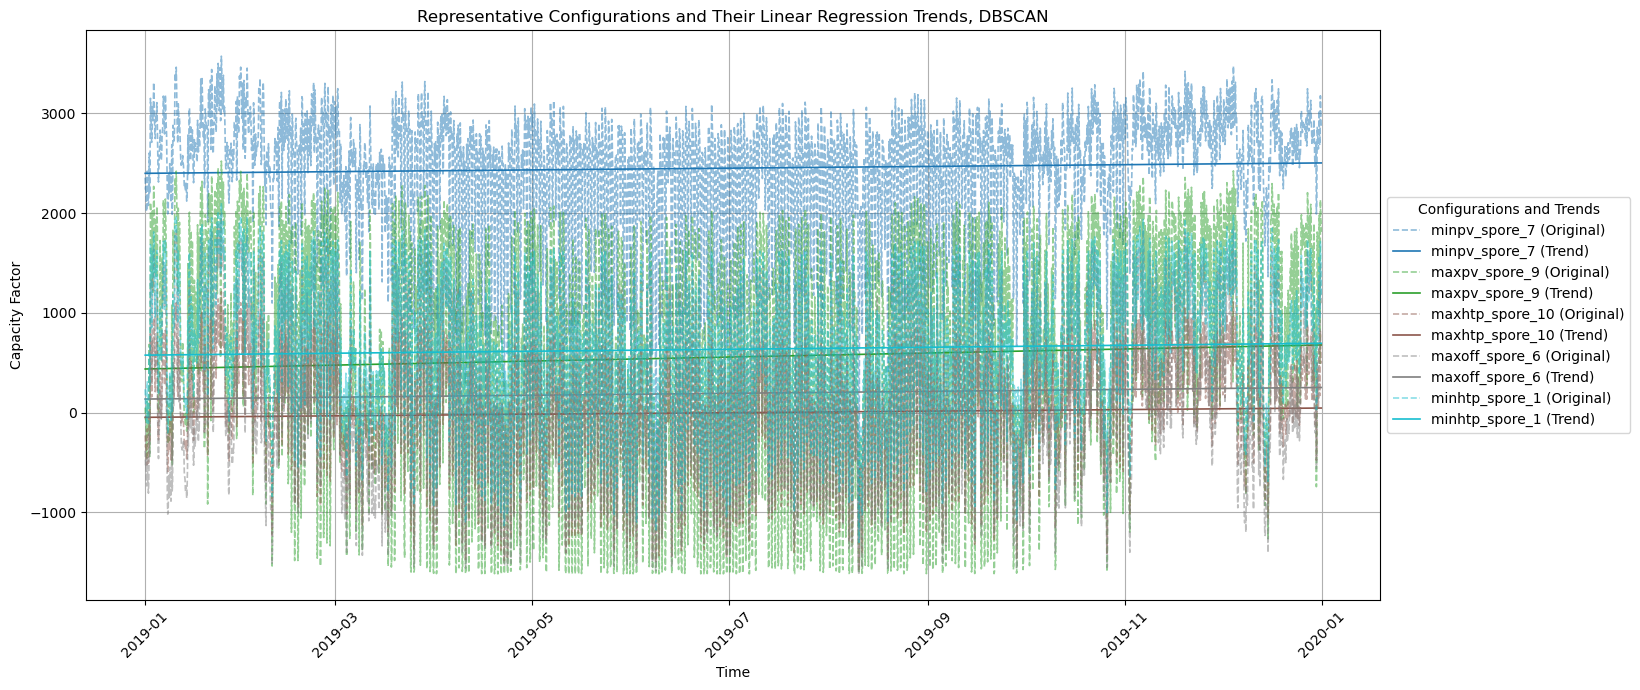

In [65]:
from scipy.stats import linregress
import matplotlib.cm as cm

# Plotting the representative configurations and their linear regression trends

# Initialize the plot
plt.figure(figsize=(14, 7))

# Loop through each representative configuration (row in df_representative_configs)
for i, config in enumerate(df_representative_configs.index):
    cluster_id_n = aggregated_matrix.loc[config, 'Cluster_DBSCAN']
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Perform linear regression to get the slope and intercept
    time = np.arange(len(config_data))  # Time indices for each timestep
    slope, intercept, _, _, _ = linregress(time, config_data.values)
    
    # Generate the regression line (linear trend)
    regression_line = slope * time + intercept

    # Use a colormap to assign a unique color for each configuration
    base_color = cm.tab10(i % 10)
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'{config} (Original)', linestyle='--', color=cluster_color_map[cluster_id_n], linewidth=1.2, alpha=0.5)
    
    # Plot the linear regression line
    trend_color = base_color
    plt.plot(df_representative_configs.columns, regression_line, label=f'{config} (Trend)', linestyle='-', color=cluster_color_map[cluster_id_n], linewidth=1.2)

# Customize the plot
plt.title('Representative Configurations and Their Linear Regression Trends, DBSCAN')
plt.xlabel('Time')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Configurations and Trends')
plt.show()

In [36]:
with pd.ExcelWriter('results/output_DBSCAN_time.xlsx', engine='openpyxl') as writer:
    cluster_spore_count.to_excel(writer, sheet_name='spore_count', index=True)
    cluster_summary.to_excel(writer, sheet_name='cluster_summary', index=True)
    df_representative_configs.to_excel(writer, sheet_name='representative_configs', index=True)
    metrics_summary.to_excel(writer, sheet_name='metrics_summary', index=False)
    metrics_df.to_excel(writer, sheet_name='statistics', index=True)
    slopes_df.to_excel(writer, sheet_name='slopes', index=False)